In [29]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

# Decided to use inverse document frequency instead of tokens. Tried analyzing data patterns for token, but inputs seemed
# too diverse to find an obvious pattern of words to be used as stop words.

In [37]:
# 1. pre processing
# 2. bag of words
# 3. lemmatization - specific to english - normalizes the word base (do, does, doing, etc...) tries to capture the root of the word despite tenses

x_train_df = pd.read_csv('./data/data_reviews/curated_texts.csv')
y_train_df = pd.read_csv('./data/data_reviews/y_train.csv')
x_test_df = pd.read_csv('./data/data_reviews/curated_texts_test.csv')

y = y_train_df.values.ravel()

print(x_train_df)

      Unnamed: 0                                               text
0              0  oh and i forgot to also mention the weird colo...
1              1                        that one didn't work either
2              2                                  waste of 13 bucks
3              3  product is useless since it does not have enou...
4              4  none of the three sizes they sent with the hea...
...          ...                                                ...
2395        2395  the sweet potato friezes were very good and se...
2396        2396      i could eat their brushed all day it is devil
2397        2397                                ambiance is perfect
2398        2398  we ordered the duck rare and it was pink and t...
2399        2399        service was good and the company was better

[2400 rows x 2 columns]


In [38]:
from nltk.stem.porter import PorterStemmer

# PRE-PROCESSING DATA

#1: Treating text list: Remove all non alpha numberic characters, make all lower case
# rethink about removing ponctuation and misspelled words.
# mltk has some functions that do that. Also conjugated words like don't

p = re.compile(r"(\b[-']\b)|[\W_]") # Regex for curating special characters
curated_texts = []
for i, text in enumerate(x_train_df['text']):
    text = text.lower() 
    text = p.sub(lambda m: (m.group(1) if m.group(1) else " "), text) # Removing special characters but `/-
    text = re.sub(' +', ' ', text) # removing multiple spaces
    text = text.strip() # removing trailing spaces        
    curated_texts.append(text)

In [39]:
import nltk
nltk.download('brown')
from nltk.corpus import brown
correct_words = brown.words()

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Igor\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [40]:
# CORRECTINGS WRONG WORDS
# importing jaccard distance
# and ngrams from nltk.util
from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams

a = set(correct_words)

# loop for finding correct spellings
# based on edit distance and
# printing the correct words

for i, text in enumerate(curated_texts):
    tmp = []
    for word in text.split(" "):
        if word not in a:
            temp = [(jaccard_distance(set(ngrams(word, 2)),
                              set(ngrams(w, 2))),w)
            for w in correct_words if w[0]==word[0]]
            word = sorted(temp, key = lambda val:val[0])[0][1]
        tmp.append(word)
    curated_texts[i] = " ".join(tmp)

In [43]:
d = pd.DataFrame(data=curated_texts)
d.to_csv('curated_texts_test.csv')

In [44]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Igor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Igor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Igor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [45]:
# LEMMATIZING

from nltk.stem import WordNetLemmatizer
import nltk

lemmatizer = WordNetLemmatizer()

corrected_texts = []
for i, text in enumerate(curated_texts):
    tmp = []
    words = nltk.word_tokenize(text) 
    words_tagged = nltk.pos_tag(words)
    for word in text.split(" "):
        if word in words_tagged:
            temp = lemmatizer.lemmatize(word, pos = "a")
        else:
            temp = lemmatizer.lemmatize(word)
        tmp.append(temp)
    curated_texts[i] = " ".join(tmp)

In [46]:
d = pd.DataFrame(data=curated_texts)
d.to_csv('curated_texts_test.csv')

In [47]:
# STOP WORDS

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = ENGLISH_STOP_WORDS

In [50]:
from nltk.stem.porter import PorterStemmer

# What cutoff for stop words? maybe look for a premade list of stop words.

def stop_stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    
    # remove stops using nltk
    #words = [w for w in words if w not in stop_words]
    
    # stem the remaining words after removing stops; 
    # what happens if we do this *before* removing stops?
    porter_stemmer = PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    
    return words

In [51]:
print(x_test_df['0'])

0      technically the film is well made with impress...
1      the owner really really need to quit being soo...
2                                  what a disappointment
3                  the movie is terribly boring in place
4      one of the best mechanical movie ever and one ...
                             ...                        
595        this is a great restaurant at the mandate bay
596       i could care le the interior is just beautiful
597    the only consistent thread holding the series ...
598    my side green salad with the green dressing wa...
599    however my recent experience at this particula...
Name: 0, Length: 600, dtype: object


In [56]:
#CONTROL PARAMETERS AND EXPLANATION

NGRAM_RANGE = (1, 2) # Will consider singular words "hi" and pairs of words "hi there" from 1 to 2 words
MAX_DF = 0.50 # Controls frequency that should be excluded. Words on the top 80% of frequency are disregarded
MIN_DF = 0.001 # Controls frequency that should be excluded. Words on the bottom 1% of frequency are disregarded
print(x_train_df)

tfidf_vectorizer = TfidfVectorizer(tokenizer=stop_stemming_tokenizer, 
                                   ngram_range = NGRAM_RANGE, 
                                   max_df = MAX_DF, 
                                   min_df = MIN_DF)
x_train = tfidf_vectorizer.fit_transform(x_train_df['text'])
pd.DataFrame(x_train.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
x_test = tfidf_vectorizer.transform(x_test_df['0'])
pd.DataFrame(x_test.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
# use grid search to get best possible values for NGRAM, and check you values for MAX_DF and MIN_DF

      Unnamed: 0                                               text
0              0  oh and i forgot to also mention the weird colo...
1              1                        that one didn't work either
2              2                                  waste of 13 bucks
3              3  product is useless since it does not have enou...
4              4  none of the three sizes they sent with the hea...
...          ...                                                ...
2395        2395  the sweet potato friezes were very good and se...
2396        2396      i could eat their brushed all day it is devil
2397        2397                                ambiance is perfect
2398        2398  we ordered the duck rare and it was pink and t...
2399        2399        service was good and the company was better

[2400 rows x 2 columns]


,1,1 2,1 star,10,10 minut,10 out,100,12,15,2,...,your,your money,your phone,your time,yourself,yourself a,yuh,zero,zero star,zombi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
#CONTROL PARAMETERS AND EXPLANATION

NGRAM_RANGE = (3, 6) # Will consider singular words "hi" and pairs of words "hi there" from 1 to 2 words
MAX_DF = 0.50 # Controls frequency that should be excluded. Words on the top 80% of frequency are disregarded
MIN_DF = 0.001 # Controls frequency that should be excluded. Words on the bottom 1% of frequency are disregarded

tfidf_vectorizer_2 = TfidfVectorizer(tokenizer=stop_stemming_tokenizer, 
                                   ngram_range = NGRAM_RANGE, 
                                   max_df = MAX_DF, 
                                   min_df = MIN_DF)
x_train_2 = tfidf_vectorizer_2.fit_transform(x_train_df['text'])
pd.DataFrame(x_train_2.toarray(), columns=tfidf_vectorizer_2.get_feature_names_out())

x_test_2 = tfidf_vectorizer_2.transform(x_test_df['0'])
pd.DataFrame(x_test_2.toarray(), columns=tfidf_vectorizer_2.get_feature_names_out())
# use grid search to get best possible values for NGRAM, and check you values for MAX_DF and MIN_DF

,10 out of,a coupl of,a good way,a great deal,a great director,a great film,a long time,a lot of,a must have,a piec of,...,you don t,you get what,you get what you,you get what you pay,you get what you pay for,you have to,you pay for,you won t,you won t be,you won t be disappoint
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
#CONTROL PARAMETERS AND EXPLANATION

NGRAM_RANGE = (1, 6) # Will consider singular words "hi" and pairs of words "hi there" from 1 to 2 words
MAX_DF = 0.50 # Controls frequency that should be excluded. Words on the top 80% of frequency are disregarded
MIN_DF = 0.001 # Controls frequency that should be excluded. Words on the bottom 1% of frequency are disregarded

tfidf_vectorizer_3 = TfidfVectorizer(tokenizer=stop_stemming_tokenizer, 
                                   ngram_range = NGRAM_RANGE, 
                                   max_df = MAX_DF, 
                                   min_df = MIN_DF)
x_train_3 = tfidf_vectorizer_3.fit_transform(x_train_df['text'])
pd.DataFrame(x_train_3.toarray(), columns=tfidf_vectorizer_3.get_feature_names_out())

x_test_3 = tfidf_vectorizer_3.transform(x_test_df['0'])
pd.DataFrame(x_test_3.toarray(), columns=tfidf_vectorizer_3.get_feature_names_out())
# use grid search to get best possible values for NGRAM, and check you values for MAX_DF and MIN_DF

,1,1 2,1 star,10,10 minut,10 out,10 out of,100,12,15,...,your,your money,your phone,your time,yourself,yourself a,yuh,zero,zero star,zombi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [61]:
# Cross validation

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

RANDOM_STATE = 30098
N_SPLITS = 10
N_REPEATS = 2

def cross_val(model, x, y):
    rkf = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=RANDOM_STATE)
    scores = cross_val_score(model, x, y, cv=rkf, scoring='accuracy')
    return sum(scores)/len(scores)

In [63]:
# Part 2, Logistic Regression
# To Do: Look at log reg hw, make it so we can ouput precision, truth tables, etc..
# Decision: 10-CROSS-VALIDATION

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
accuracy = cross_val(lr, x_train_3.toarray(), y)
print(f"accuracy: {accuracy:.5f}")

accuracy: 0.82812


In [64]:
curr_model = LogisticRegression(C = 3.16227, max_iter = 40, tol=0.68129, class_weight = 'balanced')
accuracy = cross_val(curr_model, x_train.toarray(), y)
print(accuracy)

0.8395833333333332


In [65]:
curr_model_2 = LogisticRegression(C = 3.16227, max_iter = 40, tol=0.68129, class_weight = 'balanced')
accuracy_2 = cross_val(curr_model, x_train_2.toarray(), y)
print(accuracy_2)

0.5627083333333334


In [67]:
from sklearn.ensemble import VotingClassifier
eclf1 = VotingClassifier(estimators=[('lr1', curr_model), ('lr2', curr_model_2)],voting='hard')
accuracy = cross_val(eclf1, x_train.toarray(), y)
print(accuracy)

0.8395833333333332


In [71]:
# Best classifier
from sklearn.ensemble import GradientBoostingClassifier
a = GradientBoostingClassifier()
accuracy = cross_val(a, x_train.toarray(), y)
a = a.fit(x_train, y)
b = a.predict_proba(x_test)[:, 1]
np.savetxt('test_predict_boost.txt', b)

In [73]:
best_max = 0
f_b = 'auto'
for f in ['auto', 'sqrt', 'log2']:
    a = GradientBoostingClassifier(max_features=f)
    accuracy = cross_val(a, x_train.toarray(), y)
    if accuracy > best_max:
        f_b = f
        best_max = accuracy
    print(accuracy, f)

0.7760416666666666 auto
0.7777083333333332 sqrt
0.7427083333333335 log2


In [78]:
a = GradientBoostingClassifier(max_features=f, learning_rate=.3)
accuracy = cross_val(a, x_train.toarray(), y)
best_acc = 0
if accuracy > best_max:
    best_max = accuracy
    best_lr = f
print(accuracy, f)

0.7458333333333332 log2


In [79]:
a = GradientBoostingClassifier(max_features=f, learning_rate=.2)
accuracy = cross_val(a, x_train.toarray(), y)
if accuracy > best_max:
    best_max = accuracy
    best_lr = f
print(accuracy, f)

0.7397916666666666 log2


In [81]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight = 'balanced')
accuracy = cross_val(lr, x_train_3.toarray(), y)
print(f"accuracy: {accuracy:.5f}")

accuracy: 0.83021


In [83]:
# Finding best C
import warnings
warnings.filterwarnings('ignore')

C_grid = np.logspace(-9, 6, 31)
best_accuracy = 0
min_C = 0

c_values = []
for c in C_grid:
    curr_model = LogisticRegression(C = c, max_iter = 40)
    accuracy = cross_val(curr_model, x_train_3.toarray(), y)
    c_values.append((c, accuracy))
    
    if (accuracy > best_accuracy):
        min_C = c
        best_accuracy = accuracy

print(f"accuracy: {best_accuracy:.5f}, c: {min_C}")

accuracy: 0.83771, c: 3.1622776601683795


In [85]:
# Testing Solvers

for s in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    curr_model = LogisticRegression(C = min_C, class_weight = 'balanced', solver = s)
    accuracy = cross_val(curr_model, x_train_3.toarray(), y)
    print(f"accuracy: {accuracy:.5f}, solver: {s}")

accuracy: 0.83833, solver: newton-cg
accuracy: 0.83833, solver: lbfgs
accuracy: 0.83833, solver: liblinear
accuracy: 0.83854, solver: sag
accuracy: 0.83833, solver: saga


In [87]:
# Testing Tolerance

# Finding best tol
import warnings
warnings.filterwarnings('ignore')

tol_grid = np.logspace(-6, 1, 31)
best_accuracy = 0
best_tol = 0

tol_values = []
for t in tol_grid:
    curr_model = LogisticRegression(C = min_C, max_iter = 40, tol=t)
    accuracy = cross_val(curr_model, x_train_3.toarray(), y)
    tol_values.append((t, accuracy))
    
    if (accuracy > best_accuracy):
        best_tol = t
        best_accuracy = accuracy

print(f"accuracy: {best_accuracy:.5f}, tol: {best_tol}")

accuracy: 0.83958, tol: 0.23263050671536287


In [89]:
curr_model = LogisticRegression(C = min_C, max_iter = 40, tol=best_tol, class_weight = 'balanced')
accuracy = cross_val(curr_model, x_train_3.toarray(), y)
print(accuracy)

0.8387499999999999


In [96]:
from sklearn.metrics import confusion_matrix


curr_model.fit(x_train_3.toarray(), y)
y_pred = curr_model.predict(x_train_3.toarray())

num_wrong = 0
for i, v in enumerate(y_pred):
    if v != y[i]:
        if y[i] == 1:
            num_wrong += 1
            print("False Negative: " + x_train_df['text'][i])
        else:
            num_wrong += 1
            print("False Positive: " + x_train_df['text'][i])

print(num_wrong)

False Positive: i bought these hoping i could make my blue heads fit better but these things made it impossible to wear
False Positive: excellent starter wires heads
False Positive: this is infuriating
False Positive: the loudspeaker option is great the bumpers with the lights is very appealing
False Positive: very displeased
False Negative: virgin wires rocks and so does this cheap little phone
False Negative: battery charge is quite long
False Negative: someone should invented this sooner
False Negative: much less than the jawbone i was going to replace it with
False Negative: you get extra minutes so that you can carry out the call and not get cut off
False Negative: because both ears are occupied background is not distracting at all
False Negative: now i know that i made a wise decision
False Negative: i did not have any problem with this item and would order it again if needed
False Negative: setup couldn't have been simpler
False Negative: comfortable fit you need your heads to b

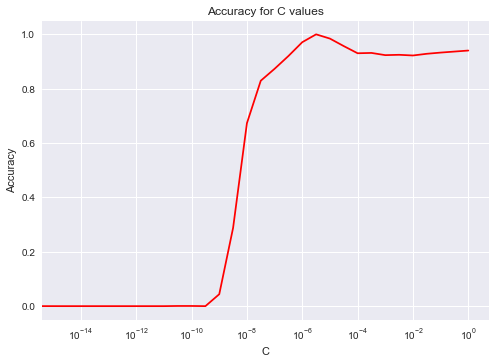

In [97]:
#plotting C values
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
c_x = [x[0] for x in c_values]
c_y = [x[1] for x in c_values]
c_x = min_max_scaler.fit_transform(np.array(c_x).reshape(-1, 1))
c_y = min_max_scaler.fit_transform(np.array(c_y).reshape(-1, 1))
plt.xscale("log")
plt.plot(c_x, c_y, color='red')
plt.title('Accuracy for C values')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

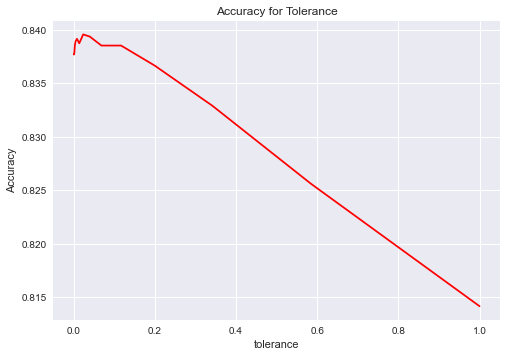

In [99]:
#plotting Tol values

from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
t_x = [x[0] for x in tol_values]
t_y = [x[1] for x in tol_values]
t_x = min_max_scaler.fit_transform(np.array(t_x).reshape(-1, 1))
plt.plot(t_x, t_y, color='red')
plt.title('Accuracy for Tolerance')
plt.xlabel('tolerance')
plt.ylabel('Accuracy')
plt.show()